# HT-MEK Data Processing Workbook for Inhibition Experiments
Author: Micah Olivas

In [144]:
# This will autoreload imported modules
%load_ext autoreload
%autoreload 2

# Import modules from folder in other directory
import sys
sys.path.insert(0, '/Users/micaholivas/Desktop/htmek_processing/single_experiment_processing')
from experiment_processing import processing

# Set up parallel processing
processing.pandarallel.initialize(progress_bar=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Import kinetic and standard series data

Read raw kinetic and standards data with Pandas

In [145]:
# csv of kinetic data from processing notebook
kinetic_data_path = '/Volumes/T7_Shield/20231003/TNO155/d2_TitrationSeries_Analysis.csv.bz2'

# csv of standard data from processing notebook
standard_data_path = '/Volumes/T7_Shield/20231003/standards/analysis/d2_PBP_StandardSeries_Analysis.csv.bz2'

# csv of egfp data from processing notebook
egfp_data_path = '/Volumes/T7_Shield/20231003/GFP/GFP_Summary.csv.bz2'

# path to egfp summary image for image segmentation and manual chamber culling
egfp_button_summary_image_path = '/Volumes/T7_Shield/20231003/GFP/20231004-161901-d2_beforeTNO/egfp/StitchedImages/SummaryImages/Summary_BGSubtracted_StitchedImg_500_egfp_0.tif'

# path to the folder where you want to save the exported data
export_path_root = "/Volumes/T7_Shield/20231003/Interpretation/TNO155"

# Point to directory for culling record export
culling_export_directory = '/Volumes/T7_Shield/20231003/Manual_culling'



# experiment information
experimental_day = '231003'
experiment_name = 'SHP2_Inhibitors'
setup = 'S2'
device = 'd2'
egfp_slope = 188847
substrate = 'DiFMUP'
inhibitor = 'TNO155'
device_columns = 32
device_rows = 56



# Create dataframes for kinetic and standard series
kinetic_data = processing.pd.read_csv(kinetic_data_path)
standard_data = processing.pd.read_csv(standard_data_path)
egfp_data = processing.pd.read_csv(egfp_data_path)
standard_data = standard_data.dropna()


# Print kinetic data head
kinetic_data.head()

,x,y,median_chamber,sum_chamber,std_chamber,x_center_chamber,y_center_chamber,radius_chamber,xslice,yslice,...,radius_button_disk_Button_Quant,median_button_annulus_Button_Quant,summed_button_annulus_normed_Button_Quant,std_button_annulus_localBG_Button_Quant,inner_radius_button_annulus_Button_Quant,outer_radius_button_annulus_Button_Quant,xslice_Button_Quant,yslice_Button_Quant,id_Button_Quant,series_index
0,1,1,1786,6450340,454,45,51,33,"(78, 178)","(747, 847)",...,15,0,12357,47,15,15,"(78, 178)","(747, 847)",A72G,0nMTNO155_100uM_DiFMUP_1
1,1,1,1488,5570864,521,45,51,33,"(78, 178)","(747, 847)",...,15,0,12357,47,15,15,"(78, 178)","(747, 847)",A72G,0nMTNO155_100uM_DiFMUP_1
2,1,1,1509,5640887,516,45,51,33,"(78, 178)","(747, 847)",...,15,0,12357,47,15,15,"(78, 178)","(747, 847)",A72G,0nMTNO155_100uM_DiFMUP_1
3,1,1,1858,6687407,440,45,51,33,"(78, 178)","(747, 847)",...,15,0,12357,47,15,15,"(78, 178)","(747, 847)",A72G,0nMTNO155_100uM_DiFMUP_1
4,1,1,1564,5816453,506,45,51,33,"(78, 178)","(747, 847)",...,15,0,12357,47,15,15,"(78, 178)","(747, 847)",A72G,0nMTNO155_100uM_DiFMUP_1


# CHANGE SUBSTRATE TO INHIBITOR HERE
**Development**: Extract assay data from series index; if you don't want to use this, comment out the next cell.

In [146]:
# use regex pattern to extract substrate and condition concentrations from the series_index string such as '25uM_ATP_1mM_EDTA'
tags = ['substrate_conc_uM']
series_index_pattern = r'(?P<%s>\d+\.?\d*)nM' % (tags[0])

# replace the sequence "no" in the series_index column with "0" to make it easier to convert to numeric
kinetic_data['series_index'] = kinetic_data['series_index'].str.replace('no', '0mM')

# apply regex pattern to each string in the "text" column and create new columns
kinetic_data['series_index'].str.extract(series_index_pattern)

# add inhibitor manually
kinetic_data['inhibitor'] = inhibitor

# add substrate manually
kinetic_data['substrate'] = substrate

# extract the new columns from the regex pattern and convert numeric columns to float
kinetic_data[tags] = kinetic_data['series_index'].str.extract(series_index_pattern)
kinetic_data[tags] = kinetic_data[tags].apply(processing.pd.to_numeric, errors='ignore')

# where kinetic_data[series_index] contains 'end', set value to nan
kinetic_data.loc[kinetic_data['series_index'].str.contains('end'), 'substrate_conc_uM'] = -0.1

# print(kinetic_data['inhibitor_conc_nM'].unique())
kinetic_data

,x,y,median_chamber,sum_chamber,std_chamber,x_center_chamber,y_center_chamber,radius_chamber,xslice,yslice,...,std_button_annulus_localBG_Button_Quant,inner_radius_button_annulus_Button_Quant,outer_radius_button_annulus_Button_Quant,xslice_Button_Quant,yslice_Button_Quant,id_Button_Quant,series_index,inhibitor,substrate,substrate_conc_uM
0,1,1,1786,6450340,454,45,51,33,"(78, 178)","(747, 847)",...,47,15,15,"(78, 178)","(747, 847)",A72G,0nMTNO155_100uM_DiFMUP_1,TNO155,DiFMUP,0.0
1,1,1,1488,5570864,521,45,51,33,"(78, 178)","(747, 847)",...,47,15,15,"(78, 178)","(747, 847)",A72G,0nMTNO155_100uM_DiFMUP_1,TNO155,DiFMUP,0.0
2,1,1,1509,5640887,516,45,51,33,"(78, 178)","(747, 847)",...,47,15,15,"(78, 178)","(747, 847)",A72G,0nMTNO155_100uM_DiFMUP_1,TNO155,DiFMUP,0.0
3,1,1,1858,6687407,440,45,51,33,"(78, 178)","(747, 847)",...,47,15,15,"(78, 178)","(747, 847)",A72G,0nMTNO155_100uM_DiFMUP_1,TNO155,DiFMUP,0.0
4,1,1,1564,5816453,506,45,51,33,"(78, 178)","(747, 847)",...,47,15,15,"(78, 178)","(747, 847)",A72G,0nMTNO155_100uM_DiFMUP_1,TNO155,DiFMUP,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241915,32,56,1566,4553375,407,35,53,31,"(6459, 6559)","(7034, 7134)",...,90,15,15,"(6459, 6559)","(7034, 7134)",blank,0nMTNO155_100uM_DiFMUP_end_1,TNO155,DiFMUP,-0.1
241916,32,56,1572,4566516,405,35,53,31,"(6459, 6559)","(7034, 7134)",...,90,15,15,"(6459, 6559)","(7034, 7134)",blank,0nMTNO155_100uM_DiFMUP_end_1,TNO155,DiFMUP,-0.1
241917,32,56,1571,4597333,404,35,53,31,"(6459, 6559)","(7034, 7134)",...,90,15,15,"(6459, 6559)","(7034, 7134)",blank,0nMTNO155_100uM_DiFMUP_end_1,TNO155,DiFMUP,-0.1
241918,32,56,1553,4516378,412,35,53,31,"(6459, 6559)","(7034, 7134)",...,90,15,15,"(6459, 6559)","(7034, 7134)",blank,0nMTNO155_100uM_DiFMUP_end_1,TNO155,DiFMUP,-0.1


In [147]:
# Format all dataframes
standard_data, kinetic_data = processing.format_data(standard_data=standard_data, kinetic_data=kinetic_data, egfp_data=egfp_data)

## "Squeeze" DataFrames

At this point, our DataFrames are in a long format: each row of kinetic_data corresponds to an individual timepoint in the kinetic assays, while each row of standard_data corresponds to an individual standard concentration. To support vectorized curve fitting operations later, we want to flatten or "squeeze" rows of each DataFrame into series (e.g. time, intensity, standard concentration) by chamber.

In [148]:
kinetic_data['MutantID'] = kinetic_data['id'].astype(str)

In [149]:
squeeze_kinetics = processing.squeeze_kinetics(kinetic_data, additional_columns=[])

,x,y,Indices,MutantID,substrate,substrate_conc_uM,summed_button_BGsub_Button_Quant,time_s,kinetic_median_intensities
0,1,1,"01,01",A72G,DiFMUP,-0.1,3132,"[0, 75, 150, 225, 300, 375, 450, 525, 600, 675...","[1245, 1251, 1262, 1274, 1285, 1298, 1296, 131..."
1,1,1,"01,01",A72G,DiFMUP,0.0,3132,"[0, 75, 150, 225, 300, 375, 450, 525, 600, 675...","[1417, 1435, 1447, 1488, 1509, 1522, 1532, 156..."


"Squeeze" standard data to serialize standard concetrations. Plot representative standard curves

,x,y,Indices,standard_concentration_uM,standard_median_intensities
0,1,1,"01,01","[0, 1, 2, 5, 10, 20, 50, 100]","[972, 1160, 1334, 1836, 2640, 4001, 7823, 13561]"
1,1,2,"01,02","[0, 1, 2, 5, 10, 20, 50, 100]","[1023, 1230, 1425, 1976, 2848, 4350, 8528, 14771]"
2,1,3,"01,03","[0, 1, 2, 5, 10, 20, 50, 100]","[1038, 1251, 1451, 2023, 2915, 4439, 8717, 15043]"
3,1,4,"01,04","[0, 1, 2, 5, 10, 20, 50, 100]","[1034, 1246, 1441, 2009, 2894, 4408, 8628, 14832]"


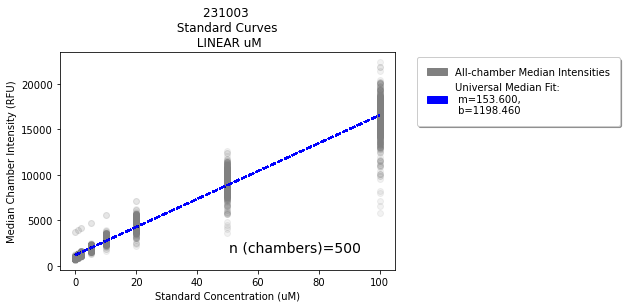

In [150]:
squeeze_standards = processing.squeeze_standard(standard_data,
                                                standard_type='linear', pbp_conc=50,
                                                experiment_day=experimental_day,
                                                remove_concs=[])

## Calculate enzyme concentration from eGFP fluorescence

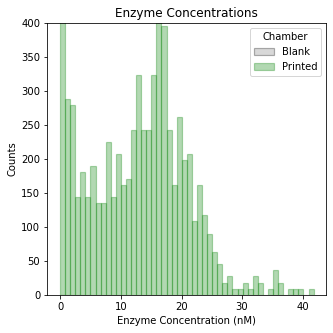

In [151]:
# adjust the enzyme concentrations by the egfp slope
squeeze_kinetics['EnzymeConc'] = squeeze_kinetics['summed_button_BGsub_Button_Quant']/egfp_slope


import matplotlib.pyplot as plt

# plot a histogram of enzyme conc for blank chambers
blank_dat = squeeze_kinetics[squeeze_kinetics['MutantID'] == 'BLANK']
plt.hist(blank_dat['EnzymeConc'], color='grey', alpha=0.3, linewidth=1.2, edgecolor='black', bins=50, label='Blank')

# plot a histogram of enzyme conc for non-blank chambers
non_blank_dat = squeeze_kinetics[squeeze_kinetics['MutantID'] != 'BLANK']
plt.hist(non_blank_dat['EnzymeConc'], color='green', alpha=0.3, linewidth=1.2, edgecolor='green', bins=50, label='Printed')

# adjust labels and plot
plt.ylim(0, 400)
plt.title('Enzyme Concentrations')
plt.xlabel('Enzyme Concentration (nM)')
plt.ylabel('Counts')
plt.legend(title='Chamber')

# adjust ratio of figure size to make it more square
plt.gcf().set_size_inches(5, 5)

plt.show()

## Fit PBP Standard Curves

To fit the PBP standard curve, we need to optimize a nonlinear least squares fit based on the following single-site binding isotherm for the phosphate sensor:

$I([Pi]) = 0.5A(KD +[Pi]+[PS]-\sqrt{(KD +[PS]+[Pi])^2 - 4[PS][Pi]}) + I(0μM)$

where $I([Pi])$ is the median fluorescence at a given $[Pi]$, $[PS]$ is the concentration of PBP, $K_D$ is the dissociation constant of Pi from PBP, $A$ is the scaling factor necessary to relate fraction PBP bound to observed fluorescence, and $I(0μM[Pi])$ is the median fluorescence intensity of PBP in the absence of added Pi.

To find product concentrations from measured intensities, we need to invert this isotherm. For this, we use the package `sympy`, which has a nice suite of tools for symbolic math.

In [152]:
# A, KD, P_i, PS, I_0uMP_i, I_P_i = symbols('A KD P_i PS I_0uMP_i I_P_i')

# isotherm_inverse = solve(0.5 * A * (KD + P_i + PS - ((KD + PS + P_i)**2 - 4*PS*P_i)**(1/2)) + I_0uMP_i - I_P_i, P_i)
# print('Inverse of isotherm:', isotherm_inverse)

If we would like to fit the inverse, we can simply copy this function into the following cell to perform the nonlinear least squares fit. Instead, we will densely interpolate the curve fits for each chamber and use the interpolations to approximate `[Pi]` concentration. The following function optimizes a least squares fit for each standard curve in each chamber and stores the optimum paramters as a list [`A, KD, PS, I_0uMP_i`] in the column `standard_popt`.

Now, let's check a few of the curve fits to make sure they look appropriate

Performing curve fits...
Some curve fits may fail, this is expected and will be replaced with NaNs


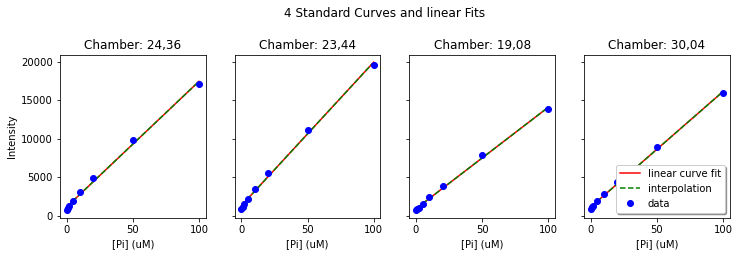

In [153]:
squeeze_standards = processing.standard_curve_fit(squeeze_standards, standard_type='linear')

## Merge dataframes

Next we merge the standard and kinetic data on the chamber Indices and substrate columns and convert the kinetic median intensities to product concentrations using the standard curve slope. To convert median assay intensities to product concentrations, we interpolate the curve fit and generate a lookup dictionary. This method should be replaced with a rigorous interpolation, but it will do for now.

In [154]:
sq_merged = processing.merge_and_get_product_concs(squeeze_kinetics, squeeze_standards, standard_type='linear')
sq_merged.head(1)

Calculating product concentrations...
(If interpolating, this will take longer than the curve fitting step)


,x,y,Indices,MutantID,substrate,substrate_conc_uM,summed_button_BGsub_Button_Quant,time_s,kinetic_median_intensities,EnzymeConc,standard_concentration_uM,standard_median_intensities,standard_popt,kinetic_product_concentration_uM
0,1,1,"01,01",A72G,DiFMUP,-0.1,3132,"[0, 75, 150, 225, 300, 375, 450, 525, 600, 675...","[1245, 1251, 1262, 1274, 1285, 1298, 1296, 131...",0.016585,"[0, 1, 2, 5, 10, 20, 50, 100]","[972, 1160, 1334, 1836, 2640, 4001, 7823, 13561]","[125.8120645626664, 1209.2914827773384]","[0.2737499999999997, 0.3354999999999997, 0.397..."


# Manual eGFP Flagging (only for [E] above the background)

In [156]:
# Initialize row and column numbers
NUM_ROWS = 56
NUM_COLS = 32

# Create button grid and display
button_grid, flagged_set, button_stamps = processing.manual_culling(sq_merged, egfp_button_summary_image_path, NUM_ROWS, NUM_COLS, culling_export_directory)
display(button_grid)

Culling record found: .../T7_Shield/20231003/Manual_culling/manual_culling_record.csv. 
Loaded culling record.


None

Close button finder, then add culling flag to merged DataFrame and export culling record

In [157]:
# close button grid if variable exists
if type(button_grid) == type(None):
    pass
else:
    button_grid.close()

# Update sq_merged with flagged chambers and export culling record
sq_merged = processing.handle_flagged_chambers(sq_merged, flagged_set, culling_export_directory)

Found culling record for the following chambers: {'03,44'}
Added flagged chambers to sq_merged.


# Calculate initial rates
To calculate initial rates for each substrate condition, we apply an algorithm adapted from page 27 of the SI of _Markin, Mokhtari et al. 2021_

In [158]:
sq_merged = processing.get_initial_rates(sq_merged, fit_type='linear', pbp_conc=50)

1) Fitting initial rates...
Done fitting initial rates. Adding results to dataframe...

2) Fitting exponential parameters...


Done fitting exponential parameters. Adding results to dataframe...



Plotting progress curves for one random library member...


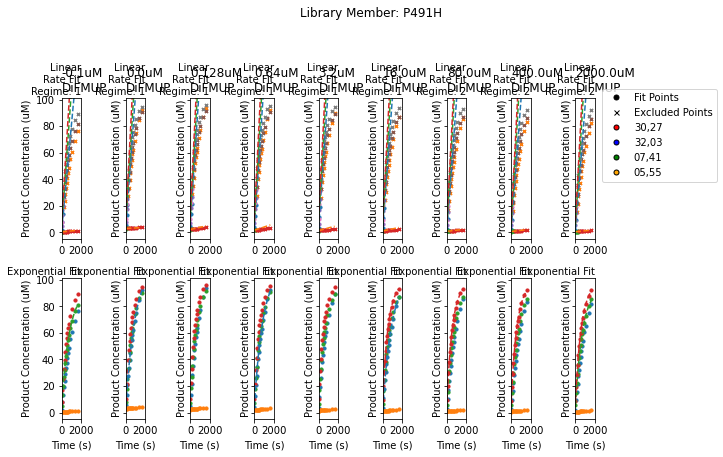

In [159]:
processing.plot_sample_progress_curves(sq_merged)

# Hill Equation Fitting

Map fits to dataframe

In [160]:
import numpy as np
from scipy.optimize import curve_fit

def ic50_curve(X, Bottom, Top, IC50, HillSlope):
        """
        X = substrate concentration
        Bottom = minimum value
        Top = maximum value
        IC50 = half-maximum value
        HillSlope = steepness of curve
        """
        return Bottom + ((Top - Bottom) / (1 + 10**((np.log10(X) - np.log10(IC50)) * HillSlope)))

# apply ic50 curve to each chamber of the dataframe
for col in range(32):
        for row in range(56):
                # get lists of initial rates and substrate concentrations
                vi_list = sq_merged[(sq_merged['y'] == row) & (sq_merged['x'] == col)]['initial_rate'].tolist()
                conc_list = sq_merged[(sq_merged['y'] == row) & (sq_merged['x'] == col)]['substrate_conc_uM'].tolist()

                # remove negative concentrations and corresponding initial rates
                for i, conc in enumerate(conc_list):
                        if conc < 0:
                                conc_list.pop(i)
                                vi_list.pop(i)

                # try to fit the curve
                try:
                        popt, pcov = curve_fit(ic50_curve, conc_list, vi_list, p0=[0, 1, 100, 1])
                        HillCurve_bottom = popt[0]
                        HillCurve_top = popt[1]
                        HillCurve_ic50 = popt[2]
                        HillCurve_hill_slope = popt[3]

                        # calculate the r squared value
                        residuals = vi_list - ic50_curve(conc_list, HillCurve_bottom, HillCurve_top, HillCurve_ic50, HillCurve_hill_slope)
                        ss_res = np.sum(residuals**2)
                        ss_tot = np.sum((vi_list - np.mean(vi_list))**2)
                        r_squared = 1 - (ss_res / ss_tot)

                        sq_merged.loc[(sq_merged['y'] == row) & (sq_merged['x'] == col), 'HillCurve_r_squared'] = r_squared
                        sq_merged.loc[(sq_merged['y'] == row) & (sq_merged['x'] == col), 'HillCurve_bottom'] = HillCurve_bottom
                        sq_merged.loc[(sq_merged['y'] == row) & (sq_merged['x'] == col), 'HillCurve_top'] = HillCurve_top
                        sq_merged.loc[(sq_merged['y'] == row) & (sq_merged['x'] == col), 'HillCurve_ic50'] = HillCurve_ic50
                        sq_merged.loc[(sq_merged['y'] == row) & (sq_merged['x'] == col), 'HillCurve_hill_slope'] = HillCurve_hill_slope

                except:
                        sq_merged.loc[(sq_merged['y'] == row) & (sq_merged['x'] == col), 'HillCurve_r_squared'] = np.nan
                        sq_merged.loc[(sq_merged['y'] == row) & (sq_merged['x'] == col), 'HillCurve_bottom'] = np.nan
                        sq_merged.loc[(sq_merged['y'] == row) & (sq_merged['x'] == col), 'HillCurve_top'] = np.nan
                        sq_merged.loc[(sq_merged['y'] == row) & (sq_merged['x'] == col), 'HillCurve_ic50'] = np.nan
                        sq_merged.loc[(sq_merged['y'] == row) & (sq_merged['x'] == col), 'HillCurve_hill_slope'] = np.nan

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_43281/3298553431.py:12: RuntimeWarning: divide by zero encountered in log10
  return Bottom + ((Top - Bottom) / (1 + 10**((np.log10(X) - np.log10(IC50)) * HillSlope)))
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_43281/3298553431.py:12: RuntimeWarning: invalid value encountered in log10
  return Bottom + ((Top - Bottom) / (1 + 10**((np.log10(X) - np.log10(IC50)) * HillSlope)))
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_43281/3298553431.py:12: RuntimeWarning: divide by zero encountered in log10
  return Bottom + ((Top - Bottom) / (1 + 10**((np.log10(X) - np.log10(IC50)) * HillSlope)))
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_43281/3298553431.py:12: RuntimeWarning: divide by zero encountered in log10
  return Bottom + ((Top - Bottom) / (1 + 10**((np.log10(X) - np.log10(IC50)) * HillSlope)))
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_43281/3298553431.py:12: RuntimeWar

Plot a few chambers to make sure the data look reasonable

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_43281/3406877874.py:36: RuntimeWarning: invalid value encountered in log10
  interp_x = np.logspace(np.log10(I_list.min()), np.log10(I_list.max()), 100)
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_43281/3406877874.py:36: RuntimeWarning: invalid value encountered in log10
  interp_x = np.logspace(np.log10(I_list.min()), np.log10(I_list.max()), 100)
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_43281/3406877874.py:36: RuntimeWarning: invalid value encountered in log10
  interp_x = np.logspace(np.log10(I_list.min()), np.log10(I_list.max()), 100)
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_43281/3406877874.py:36: RuntimeWarning: invalid value encountered in log10
  interp_x = np.logspace(np.log10(I_list.min()), np.log10(I_list.max()), 100)


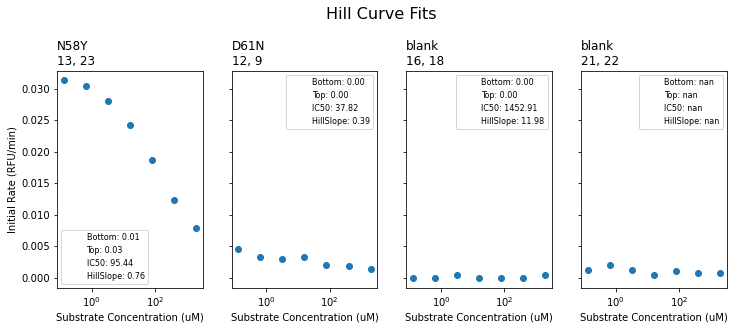

In [163]:
import matplotlib.patches as mpatches

# select 4 random xy coordinates that aren't blank
xy = sq_merged[(sq_merged['MutantID'] != 'BLANK')].sample(4)[['x', 'y']].values

# create figure with row of plots
fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharey=True)

# iterate through each xy coordinate
for n, chamber in enumerate(xy):
    # select data for xy coordinates
    xy_dat = sq_merged[(sq_merged['x'] == chamber[0]) & (sq_merged['y'] == chamber[1])]
    
    # store data in lists
    vo_list = xy_dat['initial_rate'].values
    I_list = xy_dat['substrate_conc_uM'].values
    
    # get fit parameters from dataframe
    HillCurve_bottom = xy_dat['HillCurve_bottom'].values[0]
    HillCurve_top = xy_dat['HillCurve_top'].values[0]
    HillCurve_ic50 = xy_dat['HillCurve_ic50'].values[0]
    HillCurve_hill_slope = xy_dat['HillCurve_hill_slope'].values[0]
    
    mutID_current = xy_dat['MutantID'].values[0]
    # split mutID_current on nearest underscore to 10 characters if longer than 10 characters
    if len(mutID_current) > 20:
        # get index of nearest underscore
        underscore_index = mutID_current[:20].rfind('_')
        # split mutID_current on underscore
        mutID_current = mutID_current[:underscore_index] + '\n' + mutID_current[underscore_index+1:]
    
    # plot curve
    axes[n].plot(I_list, vo_list, 'o', label='data')

    # interpolate curve
    interp_x = np.logspace(np.log10(I_list.min()), np.log10(I_list.max()), 100)
    axes[n].plot(interp_x, ic50_curve(interp_x, HillCurve_bottom, HillCurve_top, HillCurve_ic50, HillCurve_hill_slope), label='fit')
    axes[n].set_title(mutID_current + '\n' + str(chamber[0]) + ', ' + str(chamber[1]), loc='left')
    axes[n].set_xlabel('Substrate Concentration (uM)')
    axes[n].set_xscale('log')

    # add legend to each plot to show fit parameters
    handles = [
        mpatches.Patch(color='none', label='Bottom: %.2f' % HillCurve_bottom),
        mpatches.Patch(color='none', label='Top: %.2f' % HillCurve_top),
        mpatches.Patch(color='none', label='IC50: %.2f' % HillCurve_ic50),
        mpatches.Patch(color='none', label='HillSlope: %.2f' % HillCurve_hill_slope)
    ]

    axes[n].legend(handles=handles, fontsize=8)


# create legend with HillSlope and IC50 values
axes[0].set_ylabel('Initial Rate (RFU/min)')

# add suptitle
fig.suptitle('Hill Curve Fits', fontsize=16, y=1.1)

plt.show()

# Calculate local background ratio
Add as a row in the by-chamber, by-substrate concentration dataframe, then squeeze into a list in the MM dataframe 

Next, iterate row-wise across the dataframe and compute the local background ratio. This algorithm is as follows: 
    1) for each chamber, store the intial rate for the highest substrate concentration condition
    2) coerce all rates below 0.00001 to zero
    3) store the rates in the above and below chambers

In [166]:
from tqdm import tqdm
import pandas as pd

def calculate_local_bg_ratio(sq_merged, target_substrate_conc, device_rows):
    """Calculate local background ratio for every chamber.

    Parameters:
    squeeze_mm (pandas dataframe): dataframe containing squeeze data
    sq_merged (pandas dataframe): dataframe containing merged squeeze data
    device_rows (int): number of rows in device
    exclude_concs (list): list of concentrations to exclude from local background calculation

    Returns:
    squeeze_mm (pandas dataframe): dataframe containing squeeze data with local background ratio added
    """

    # get set of substrate concs
    substrate_concs = set(sq_merged.substrate_conc_uM)

    # save this as a df
    local_bg_df = sq_merged.copy()
    local_bg_df['index_tuple'] = local_bg_df.apply(lambda row: (row.x, row.y), axis=1)
    local_bg_df = local_bg_df.reset_index()  # make sure indexes pair with number of rows
    local_bg_df['initial_rate'] = local_bg_df['initial_rate'].round(5)

    # # merge exclude concs from squeeze_mm to local_bg_df
    # local_bg_df = local_bg_df.merge(squeeze_mm[['Indices', 'exclude_concs']], on='Indices')

    ## Select substrate conc for each local background calculation
    for index, row in tqdm(local_bg_df.iterrows(), total=len(local_bg_df), desc='Calculating local background ratios...'):
        # get list of included substrate concs
        # chamber_included_concs = [conc for conc in substrate_concs if conc not in row.exclude_concs]
        chamber_included_concs = [conc for conc in substrate_concs]

        if len(chamber_included_concs) > 0:
            # get max intial rate for included substrate concs
            # ADD THIS ^
            max_included_conc = min(chamber_included_concs)
        else:
            max_included_conc = np.nan

        # put max included conc in new column
        if target_substrate_conc != None:
            local_bg_df.loc[index, 'local_bg_substrate_conc'] = target_substrate_conc
        else:
            local_bg_df.loc[index, 'local_bg_substrate_conc'] = max_included_conc
        
    ## Remove rows from local_bg_df where substrate conc is not the max included conc
    local_bg_df = local_bg_df[local_bg_df['local_bg_substrate_conc'] == local_bg_df['substrate_conc_uM']]

    ## Local background rate calculation
    for index, row in tqdm(local_bg_df.iterrows(), total=len(local_bg_df), desc='Calculating local background rates...'):

        # store chamber details
        chamber_rate = row.initial_rate
        x = row.x
        y = row.y

        # get local (above and below) chamber neighbors
        lbg_idxs = processing.get_local_bg_indices(x,y,device_rows)

        # get rates for each of neighboring chambers
        lbg_rates = []

        for tup in lbg_idxs:
            # if chamber is in local_bg_df, get rate
            if tup in local_bg_df['index_tuple'].tolist():
                rate = local_bg_df.loc[local_bg_df['index_tuple'] == tup, 'initial_rate'].iloc[0]
            else: # if chamber is not in local_bg_df, rate is 0
                rate = 0.0000001
                
            # account for zero-slope rates
            if rate != 0:
                lbg_rates.append(rate)
            else:
                lbg_rates.append(0.0000001) # append near-zero rate to avoid dividing by zero

        # remove negative rates from list
        lbg_rates = [rate for rate in lbg_rates if rate > 0]

        # get average of lbg_rates and calculate ratio
        lbg_avg = np.mean(lbg_rates)
        
        if lbg_avg != 0: # account for zero-slope rates
            lbg_ratio = chamber_rate/lbg_avg
        else:
            lbg_ratio = 0

        # account for negative ratios
        if lbg_ratio < 0:
            lbg_ratio = 0

        # store ratio in new column
        local_bg_df.loc[index, 'local_bg_ratio'] = lbg_ratio


    # add column into sq_merged, but overwrite local_bg_ratio if it already exists
    if 'local_bg_ratio' in sq_merged.columns:
        sq_merged = sq_merged.drop(columns=['local_bg_ratio'])
    sq_merged = pd.merge(sq_merged, local_bg_df[["Indices", "local_bg_ratio", "local_bg_substrate_conc"]], on="Indices")

    # # add column into squeeze_mm, but overwrite local_bg_ratio if it already exists
    # if 'local_bg_ratio' in squeeze_mm.columns:
    #     squeeze_mm = squeeze_mm.drop(columns=['local_bg_ratio'])
    # squeeze_mm = pd.merge(squeeze_mm, local_bg_df[["Indices", "local_bg_ratio", "local_bg_substrate_conc"]], on="Indices")

    return sq_merged

In [167]:
sq_merged = calculate_local_bg_ratio(sq_merged, device_rows=device_rows, target_substrate_conc=0)

Calculating local background rates...:  53%|█████▎    | 958/1792 [00:00<00:00, 1345.71it/s]/opt/anaconda3/envs/processing_BaSiC/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/processing_BaSiC/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Calculating local background rates...: 100%|██████████| 1792/1792 [00:01<00:00, 1316.35it/s]


# Print PDFs

Generate one experiment-level summary PDF and one PDF per chamber with the following plots:
1. **Progress curves** for each substrate condition with linear initial rate fits
2. **Standard curve** 
4. **Michaelis-Menten fits** to each substrate condition

PDFs are exported to a `PDF` directory in the specified export directory.

In [168]:
# get kobs_ckat_KM from best fit
import pandas as pd

for index, row in squeeze_mm.iterrows():
    # get enzyme conc, substrate conc, kobs, and exp R^2
    enzyme_conc = row['EnzymeConc']
    substrate_concs = row['substrate_concs']
    exp_kobs = row['exponential_kobs_list']
    exp_r2 = row['exponential_R2_list']
    exp_kcat_over_KM = row['exponential_kcat_over_km_list']

    # remove points above 50 uM substrate
    max_substrate_conc = max([i for i in substrate_concs if i < 50]) # get highest substrate conc below 50 uM
    # delete all points above max_substrate_conc
    index_cutoff = substrate_concs.index(max_substrate_conc)
    exp_kobs = exp_kobs[:index_cutoff]
    exp_r2 = exp_r2[:index_cutoff]
    exp_kcat_over_KM = exp_kcat_over_KM[:index_cutoff]

    # get argmax of highest R^2
    max_r2_index = exp_r2.index(max(exp_r2))
    max_exp_R2 = exp_r2[max_r2_index]
    max_r2_kcat_over_KM = exp_kcat_over_KM[max_r2_index]

    # create new columns
    squeeze_mm.loc[index, 'max_exp_R2'] = max_exp_R2
    squeeze_mm.loc[index, 'kobs_kcat_over_KM'] = max_r2_kcat_over_KM

NameError: name 'squeeze_mm' is not defined

In [169]:
sq_merged.columns

Index(['x', 'y', 'Indices', 'MutantID', 'substrate', 'substrate_conc_uM',
       'summed_button_BGsub_Button_Quant', 'time_s',
       'kinetic_median_intensities', 'EnzymeConc', 'standard_concentration_uM',
       'standard_median_intensities', 'standard_popt',
       'kinetic_product_concentration_uM', 'egfp_manual_flag', 'initial_rate',
       'initial_rate_intercept', 'two_point_fit', 'rate_fit_regime',
       'num_points_fit_vo', 'exponential_A', 'exponential_kobs',
       'exponential_y0', 'exponential_R2', 'kobs_kcat_KM',
       'HillCurve_r_squared', 'HillCurve_bottom', 'HillCurve_top',
       'HillCurve_ic50', 'HillCurve_hill_slope', 'local_bg_ratio',
       'local_bg_substrate_conc'],
      dtype='object')

In [170]:
sq_merged['substrate_conc_uM'].unique()

array([-1.00e-01,  0.00e+00,  1.28e-01,  6.40e-01,  3.20e+00,  1.60e+01,
        8.00e+01,  4.00e+02,  2.00e+03])

/Users/micaholivas/Desktop/htmek_processing/single_experiment_processing/experiment_processing/processing.py:1599: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = ax.figure.colorbar(im, ax=ax, norm=norm, **cbar_kw)


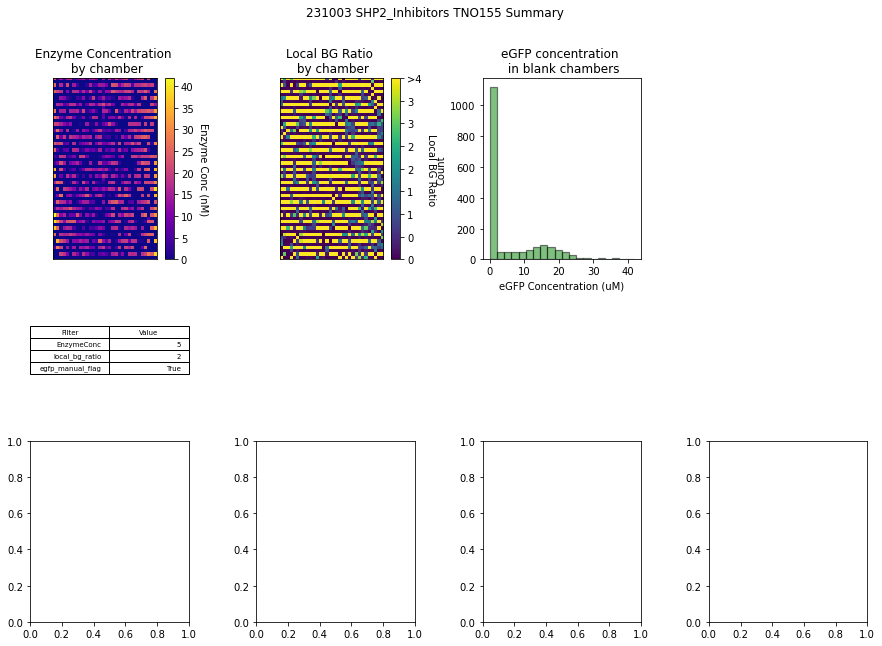

  0%|          | 0/1792 [00:00<?, ?it/s]/Users/micaholivas/Desktop/htmek_processing/single_experiment_processing/experiment_processing/processing.py:2430: RuntimeWarning: divide by zero encountered in log10
  return Bottom + ((Top - Bottom) / (1 + 10**((np.log10(X) - np.log10(IC50)) * HillSlope)))
/Users/micaholivas/Desktop/htmek_processing/single_experiment_processing/experiment_processing/processing.py:2430: RuntimeWarning: divide by zero encountered in log10
  return Bottom + ((Top - Bottom) / (1 + 10**((np.log10(X) - np.log10(IC50)) * HillSlope)))
Processing (1, 1):   0%|          | 1/1792 [00:00<15:52,  1.88it/s]/Users/micaholivas/Desktop/htmek_processing/single_experiment_processing/experiment_processing/processing.py:2430: RuntimeWarning: divide by zero encountered in log10
  return Bottom + ((Top - Bottom) / (1 + 10**((np.log10(X) - np.log10(IC50)) * HillSlope)))
/Users/micaholivas/Desktop/htmek_processing/single_experiment_processing/experiment_processing/processing.py:2430: R

In [175]:
filter_dictionary = {'local_bg_ratio': 2, 
                     'EnzymeConc': 5,
                     'egfp_manual_flag': True}

processing.plot_chip_summary_inhibition(Inhibitor=inhibitor, standard_type='linear',
                             pbp_conc=50, substrate=inhibitor, sq_merged=sq_merged, squeeze_standards=squeeze_standards, 
                             squeeze_kinetics=squeeze_kinetics, button_stamps=button_stamps, device_columns=device_columns, 
                             device_rows=device_rows, export_path_root=export_path_root, experimental_day=experimental_day, 
                             experiment_name=experiment_name, exclude_concs=[], filter_dictionary=filter_dictionary,
                             )

#### Merge PDFs

In [24]:
# merge pdfs and export to main directory
merged_file_path = processing.merge_pdfs(export_path_root=export_path_root, experimental_day=experimental_day, substrate=substrate)

Found 1768 pdfs.
Merging 1768 pdfs...


Merging PDFs:   3%|▎         | 48/1768 [00:00<00:03, 475.02it/s]

First three files: ['00_Chip_Summary.pdf', '01,01.pdf', '01,02.pdf']


Merging PDFs: 100%|██████████| 1768/1768 [00:02<00:00, 709.66it/s]


Writing merged pdf to file...
Done.


Also export to manuscript directory

In [25]:
import os

# copy merged file to manuscript directory
manuscript_directory = '/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Experiment_PDF_summaries/'

# add experimental day and substrate to manuscript directory with os
manuscript_directory = manuscript_directory + '%s/%s/' % (experimental_day, substrate)

# if directory doesn't exist, create it
if not os.path.exists(manuscript_directory):
    os.makedirs(manuscript_directory)

# copy merged file to manuscript directory
os.system('cp %s %s' % (merged_file_path, manuscript_directory))

0

# Export Data

In [175]:
processing.export_data(sq_merged=sq_merged, squeeze_mm=squeeze_mm, export_path_root=export_path_root, experimental_day=experimental_day, experiment_name=experiment_name, substrate=substrate, device=device, setup=setup)